In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sklearn.neighbors, sklearn.preprocessing, sklearn.metrics, sklearn.pipeline, sklearn.svm, sklearn.feature_selection, sklearn.neural_network, sklearn.model_selection
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('/home/hugo/Thèse/styles.mplstyle')
import seaborn as sns
import identification.dataset
import random
%matplotlib widget

In [10]:
config = {
    'frame_size': 2048,
    'hop_ratio': 1,
    'n_coeff': 60,
    'sr': 10000,
    'sample_duration': 30,
    'feature': 'MFCC_welch',
    # 'clf': sklearn.neighbors.KNeighborsClassifier(),
    # 'clf__n_neighbors': 5,
    # 'clf__p': 1,
    # 'clf__weights': 'distance',
    'clf': sklearn.svm.SVC(),
    'clf__decision_function_shape': 'ovr',
    'clf__kernel': 'linear',
    'clf__C': 1.0,
}

In [11]:
# data = pd.read_pickle('../data/processed/dataset_bilbao.pkl')
# data = data[data.type.isin(['scale', 'free']) & (data.player != 15)]

data = pd.read_pickle('../data/processed/dataset_cnsm.pkl')
data = data[(data.violin.isin(['A', 'B', 'C'])) & (data.extract != '?')]

features = identification.dataset.get_dataset(config, data)

100%|██████████| 937/937 [00:29<00:00, 31.51it/s]


In [12]:
def train(config, train_df, test_df):
    # Test / Train
    x_train = np.vstack(train_df.features)
    y_train = train_df.violin.to_numpy()
    x_test = np.vstack(test_df.features)
    y_test = test_df.violin.to_numpy()

    # Train
    estimator = config['clf']
    pipeline = sklearn.pipeline.Pipeline([
        ('scaler', sklearn.preprocessing.StandardScaler()),
        ('clf', estimator),
    ])
    valid_params = pipeline.get_params()
    params = {x:config[x] for x in config if x in valid_params}
    pipeline.set_params(**params)
    pipeline.fit(x_train, y_train)
    return pipeline.score(x_test, y_test)

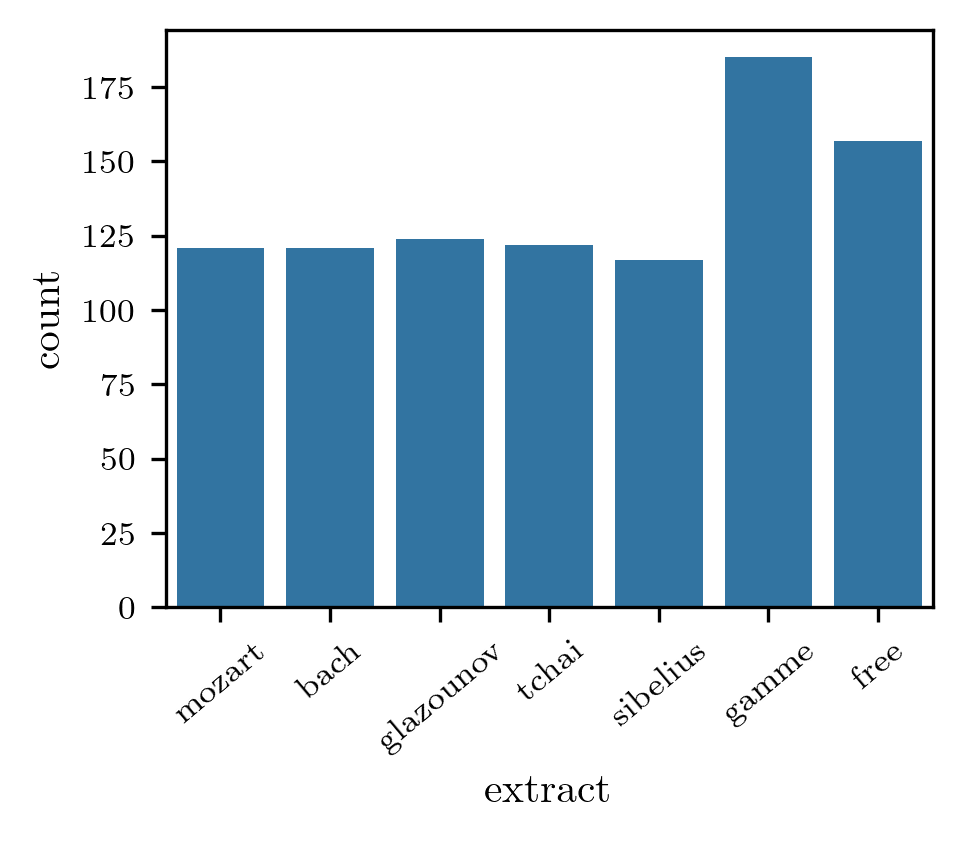

In [13]:
# test = features[features.condition == 'non-aveugle']
test = features
train_df, test_df = sklearn.model_selection.train_test_split(test, test_size=0.15, stratify=test.extract.to_numpy())
# train_df.drop_duplicates(subset=['violin', 'player', 'condition', 'extract'], inplace=True)
fig, ax = plt.subplots()
ax = sns.countplot(x="extract", data=train_df)
ax.tick_params(axis='x', rotation=40)

In [ ]:
extracts = list(set(data.extract))

scores = []
for split in range(300):
    train_df, test_df = sklearn.model_selection.train_test_split(test, test_size=0.2, stratify=test.extract.to_numpy())

    for i in range(len(extracts)):
        train_dff = train_df[train_df.extract == extracts[i]]
        score = train(config, train_dff[:60], test_df)

        scores.append({
            'score': train(config, train_dff[:60], test_df[test_df.extract == extracts[i]]),
            'extract': extracts[i],
            'type': 'same'
        })

        scores.append({
            'score': train(config, train_dff[:60], test_df[test_df.extract != extracts[i]]),
            'extract': extracts[i],
            'type': 'other'
        })
        # scores.append({'score': score, 'extract': extracts[i]})

    score = train(config, train_df[:60], test_df)
    scores.append({
        'score': score,
        'extract': 'Mix',
        'type': 'same'
    })
    scores.append({
        'score': np.nan,
        'extract': 'Mix',
        'type': 'other'
    })

scores = pd.DataFrame(scores)
scores.to_csv('../models/scores_excerpts.csv')

<>:33: SyntaxWarning: invalid escape sequence '\%'
<>:33: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_50782/3224736771.py:33: SyntaxWarning: invalid escape sequence '\%'
  ax.set_ylabel('Accuracy (\%)')


      Unnamed: 0  score    extract   type
0              0   90.0      tchai   same
1              1   75.0      tchai  other
2              2   82.0   sibelius   same
3              3   58.0   sibelius  other
4              4   96.0       bach   same
...          ...    ...        ...    ...
4791        4791   70.0     mozart  other
4792        4792   86.0  glazounov   same
4793        4793   72.0  glazounov  other
4796        4796   72.0      gamme   same
4797        4797   72.0      gamme  other

[3600 rows x 4 columns]


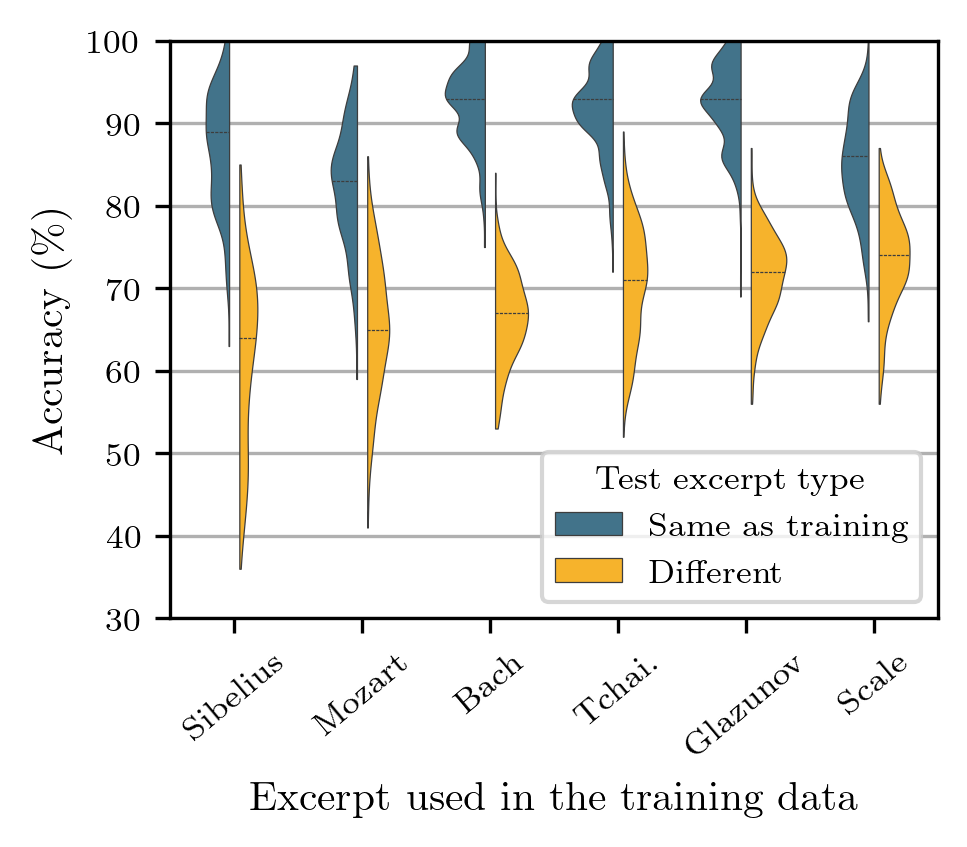

In [4]:
scores = pd.read_csv('../models/scores_excerpts.csv')

scores = scores[~scores.extract.isin(['free', 'Mix'])]

scores['score'] = np.round(scores.score * 100)
print(scores)

fig, ax = plt.subplots()
scores.replace('tchai', 'Tchai.', inplace=True)
scores.replace('gamme', 'Scale', inplace=True)
scores.replace('mozart', 'Mozart', inplace=True)
scores.replace('glazounov', 'Glazunov', inplace=True)
scores.replace('bach', 'Bach', inplace=True)
scores.replace('sibelius', 'Sibelius', inplace=True)
scores.replace('free', 'Free', inplace=True)

order = scores[scores.type == 'other'].groupby(by=['extract'])['score'].median().sort_values().index

colors = ["#42738A", "#F6B32C"]
# colors = ['#5fbfdc', '#f6ae31']

sns.violinplot(x='extract', y='score', data=scores, order=order, hue='type', split=True, inner="quart", gap=.2, linewidth=.3, cut=0, palette=colors, common_norm=True, saturation=1)

for l in ax.lines:
    if l._dash_pattern[1][0] != 0.75:
        l.remove()

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, title='Test excerpt type', labels=['Same as training', 'Different'])
ax.grid(axis = 'y')
ax.set_ylim([30, 100])
ax.set_xlabel('Excerpt used in the training data')
ax.set_ylabel('Accuracy (\%)')
ax.tick_params(axis='x', rotation=40)
plt.savefig('../reports/FA/figures/accuracy-vs-excerpt.png', dpi=600)
plt.show()

In [152]:
scores = []
for _ in range(100):
    train_df, test_df = sklearn.model_selection.train_test_split(features, test_size=0.2)
    scores.append(train(config, train_df, test_df))
print(np.median(scores))

0.8878923766816144


['constant', 'additive']


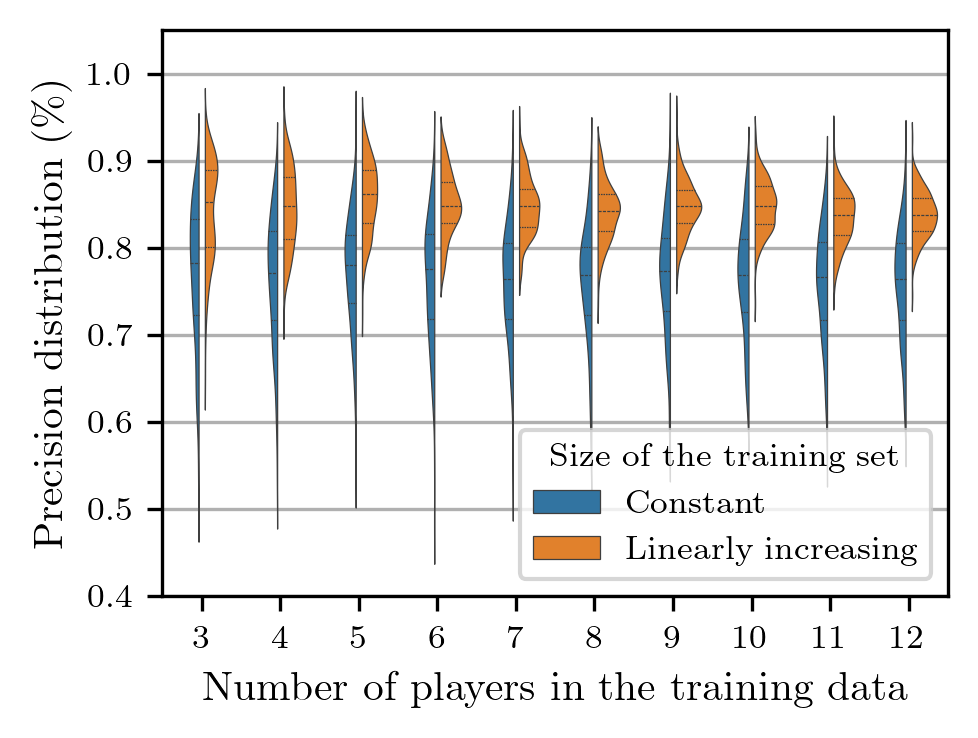

In [ ]:
names = list(set(data.player))
MIN = 3*10

def random_combination(iterable, r):
    "Random selection from itertools.combinations(iterable, r)"
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), r))
    return tuple(pool[i] for i in indices)

scores = []
for _ in range(200):
    train_df, test_df = sklearn.model_selection.train_test_split(features, test_size=0.2)
    for i in range(3, len(names), 1):
        n_per_violinist = int(MIN / i)
    # for i in tqdm.tqdm(range(2, len(names))):
        # train_df, test_df = sklearn.model_selection.train_test_split(features, test_size=0.15)
        # subsets = list(itertools.combinations(names, i))
        # random.shuffle(subsets)
        # for subset in subsets[:30]:
        # for _ in range(10):
        subset = random_combination(names, i)
        train_dff = train_df[train_df.player.isin(list(subset))]
        if len(train_dff) > MIN:
            scores.append({
                'score': train(config, train_dff[:MIN], test_df), 
                'n': i,
                'type': 'constant'
            })

        scores.append({
            'score': train(config, train_dff[:n_per_violinist * MIN // 3 * i], test_df), 
            'n': i,
            'type': 'additive'
        })
scores = pd.DataFrame.from_dict(scores)

fig, ax = plt.subplots()
stats = scores.groupby('n')['score'].agg(['mean', 'std']).reset_index()
sns.violinplot(
    x='n', y='score', data=scores, 
    hue='type', 
    split='True', 
    inner='quart', 
    # color='orange',
    gap=.2, 
    linewidth=.3,
    common_norm=True,   # https://github.com/mwaskom/seaborn/issues/3799
)

# for l in ax.lines:
#     if l._dash_pattern[1][0] != 0.75:
#         l.remove()

ax.grid(axis = 'y')
ax.set_axisbelow(True)
ax.set_xlabel('Number of players in the training data')
ax.set_ylabel('Precision distribution (\\%)')
handles, labels = ax.get_legend_handles_labels()
print(labels)
ax.legend(handles=handles, title='Size of the training set', labels=['Constant', 'Linearly increasing'])
ax.set_ylim([0.4,1.05])
plt.tight_layout()
plt.savefig('../reports/figures/precision_bilbao.png')
plt.show()

In [7]:
import random

def random_combination(iterable, r):
    "Random selection from itertools.combinations(iterable, r)"
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), r))
    return tuple(pool[i] for i in indices)

violins = data["violin"].unique()
players = data["player"].unique()

def sample_rows(i, j):
    subset = random_combination(names, i)
    # print(subset)

    samples_per_violin = j // len(violins)
    remaining = j % len(violins)
    # print(f'Samples per violin : {samples_per_violin}')
    # print(f'Remaining : {remaining}')

    sampled_dfs = []
    for l, player in enumerate(subset):
        player_df = train_df[train_df.player == player]
        random.shuffle(violins)
        for k, violin in enumerate(violins):
            violin_df = player_df[player_df.violin == violin]
            n_samples = samples_per_violin + (1 if k < remaining else 0)
            if len(violin_df) >= n_samples:
                sampled = violin_df.sample(n_samples)
                sampled_dfs.append(sampled)
            else:
                sampled_dfs.append(violin_df)

    final_sample = pd.concat(sampled_dfs)

    # final_sample = (
    #     players_df.groupby(["violin", "player"], group_keys=False)
    #     .apply(lambda x: x.sample(frac=j/len(players_df), random_state=42))
    # )

    # final_sample = players_df.groupby('player')[['features', 'violin', 'player', 'extract']].apply(lambda s: s.sample(j))

    # print(final_sample[['player', 'violin', 'extract']])
    return final_sample[['player', 'violin', 'extract', 'features']]

# sample_rows(2, 4)

In [42]:
features = features[features.player != 'Antonin']
names = list(set(features.player))
violins = data["violin"].unique()
scores = []

for _ in range(100):
    train_df, test_df = sklearn.model_selection.train_test_split(features, test_size=0.2)

    for i in range(1, len(names)+1) :
        for j in range(5, 60, 5):
        # for j in range(5, 60, 2):
            # subset = random_combination(names, i)
            # players_df = train_df[train_df.player.isin(list(subset))]

            # final_sample = (
            #     players_df.groupby(["violin", "player"], group_keys=False)
            #     .apply(lambda x: x.sample(frac=j/len(players_df), random_state=42))
            # )

            # samples_per_violin = j // len(violins)
            # remaining = j % len(violins) 

            # sampled_dfs = []
            # for k, violin in enumerate(violins):
            #     violin_df = players_df[players_df["violin"] == violin]
            #     n_samples = samples_per_violin + (1 if k < remaining else 0)
            #     if len(violin_df) >= n_samples:
            #         sampled = violin_df.sample(n_samples)
            #         sampled_dfs.append(sampled)
            #     else:
            #         sampled_dfs.append(violin_df)

            # final_sample = pd.concat(sampled_dfs)

            # train_dff = train_dff.groupby('player')[['features', 'violin']].apply(lambda s: s.sample(j))

            final_sample = sample_rows(i, j)
            scores.append({
                'score': train(config, final_sample, test_df), 
                'i': i,
                'j': j,
            })

scores = pd.DataFrame(scores)

In [43]:
scores.to_csv('../models/scores2.csv')

<>:42: SyntaxWarning: invalid escape sequence '\%'
<>:42: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_36796/3331778190.py:42: SyntaxWarning: invalid escape sequence '\%'
  text = ax.text(x0 + (j + 0.5) / width * (x1 - x0), y0 + (i + 0.5) / height * (y1 - y0), f"{int(agg.iloc[i, j])}\%", ha="center", va="center", color="black", size=4, fontweight='black')


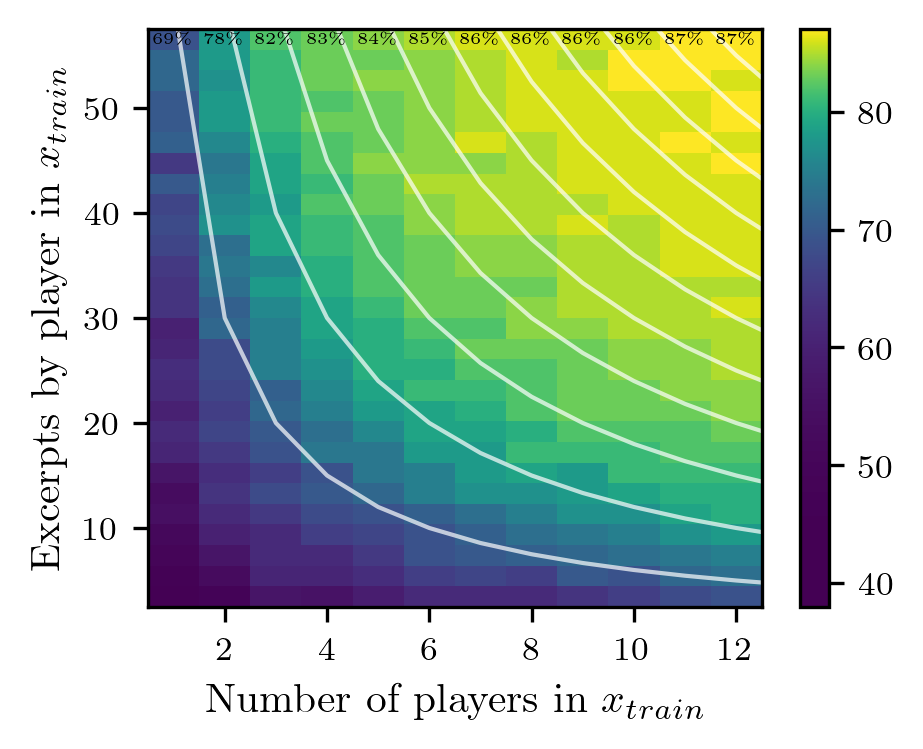

In [27]:
# colors = ["#42738A", "#42738A", "#80A539", "#F6B32C", "#F6B32C"]
# colors = ["#2A4F63", "#42738A", "#6A8E5F", "#80A539", "#B38E2A", "#E0A42C", "#F6B32C"]
# color_positions = [0, 0.3, 0.5, 0.7, 0.9, 1.0]
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list('FA', colors, N=100)
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list('FA', list(zip(color_positions, colors)))

scores = pd.read_csv('../models/scores.csv')
agg = pd.DataFrame()
agg['mean'] = scores.groupby(['i', 'j'])['score'].mean()
agg = agg.reset_index()
agg['mean'] = np.round(agg['mean'] * 100)

agg = agg.pivot(columns='i', index='j', values='mean')

# Plotspdf
fig, ax = plt.subplots()

extent = [0.5, 12.5, 2.5, 57.5]
x0, x1, y0, y1 = extent
height  = len(agg.index.values)
width   = len(agg.columns.values)

for i in range(1, 13):
    x = np.arange(i, 14)
    y = (i*60) / (x)
    ax.plot(x, y, color="white", linewidth=1, alpha=.7)

im = ax.imshow(agg, origin='lower', extent=extent, aspect='auto', cmap='viridis', norm= matplotlib.colors.PowerNorm(gamma=3))
cb = fig.colorbar(im)
cb.ax.set_yscale('linear')
# ax.set_yticks(np.arange(0, len(agg.index.values)))
# ax.set_yticklabels(agg.index.values)
# ax.set_xticks(np.arange(0, len(agg.columns.values)))
# ax.set_xticklabels(agg.columns.values)
ax.set_xlabel('Number of players in $x_{train}$')
ax.set_ylabel('Excerpts by player in $x_{train}$')

for i in range(len(agg.index.values)):
    for j in range(len(agg.columns.values)):
        if i != (len(agg.index.values) - 1) :
            continue
        text = ax.text(x0 + (j + 0.5) / width * (x1 - x0), y0 + (i + 0.5) / height * (y1 - y0), f"{int(agg.iloc[i, j])}\%", ha="center", va="center", color="black", size=4, fontweight='black')

# np.round(agg.iloc[i, j], 2)

plt.savefig(f'../reports/FA/figures/matrix.png')